In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import modules
import os
from env import host, user, password

# wrangling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# notebook setting configuration
# pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', 100)

# Zillow
<hr>
For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

## Acquire and Summarize

### 1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. 
Make sure to include: 
- the **`logerror`**, 
- all fields related to the properties that are available. 

You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a **transaction in 2017**, and include only **the last transaction for each property** (so no duplicate property ID's), along with **`zestimate error`** and date of transaction.
- Only include properties that include a **`latitude`** and **`longitude value`**.

In [2]:
# parts of acquire_data() function

# 1) query
query = """SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
       
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
                        logerror,
                        Max(transactiondate) transactiondate 
                        FROM   predictions_2017 
                        GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 

WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

In [3]:
# 2) database

database = 'zillow'

In [4]:
# 3) url string

url = f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [5]:
# 4) read sql query into df using query and url string

pd.read_sql(query, url)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037132e+13,-0.002245,2017-09-20,Central,None,None,Central,Condominium,None,None
77570,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,6.037101e+13,0.020615,2017-09-20,None,None,None,Central,Single Family Residential,None,None
77571,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,6.111008e+13,0.013209,2017-09-21,None,None,None,None,Single Family Residential,None,None
77572,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,6.037434e+13,0.037129,2017-09-21,Central,None,None,Central,Single Family Residential,None,None


>### `acquire_data()` function

In [6]:
def acquire_data(file_name, database, query):
    '''
THIS FUNCTION TAKES IN:
    (1) A CSV FILE NAME ***MAKE SURE YOU INCLUDE .CSV EXT*** 
    (2) DATABASE NAME AND 
    (3) SQL QUERY STRING 
AND RETURNS A PANDAS DF BY:
        (i.) CHECKING TO SEE IF LOCAL CSV FILE WITH DATA EXISTS
        (ii.) WRITING THE LOCAL CSV FILE OT PANDAS DF 
OR, IF LOCAL CSV DOES NOT EXIST:
        (i.) IMPORTING DATABASE CONNECTION CREDENTIALS
        (ii.) USING CREDENTIALS TO CREATE DATABASE CONNECTION STRING
        (iii.) READING THE SQL QUERY INTO A DF
        (iv.) CACHING DF AND SAVING DATA AS LOCAL CSV FILE
    '''
    # checking for local csv file
    if os.path.isfile(file_name):
        
        # reading csv file to pandas df
        df = pd.read_csv(file_name)
        
    # or, if no local csv file
    else:

        # url database connection string 
        url = f'mysql+pymysql://{user}:{password}@{host}/{database}'

        # reading sql query into df using sql query and url string
        df = pd.read_sql(query, url)
        
        # write df to local csv file
        df.to_csv(file_name)
    
    return df 

In [7]:
zillow_data = acquire_data('zillow_data.csv', 'zillow', query)

### 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)
> ### `summarize_data()` function

In [8]:
def summarize_data(df, num_unique_cols):
    '''
THIS FUNCTIONS TAKES IN A DATAFRAME AND THE MAX NUMBER OF UNIQUE COLUMN VALUES TO 
PRINT VALUE_COUNTS FOR AND PRINTS THE FOLLOWING SUMMARY INFORMATION:
    1) DF SHAPE, NUMBER OF ROWS AND COLUMNS
    2) DF INFO
    3) THE UNIQUE VALUES IN THE DF COLUMNS (NUMBER AND, IF <= 10, EACH UNIQUE VALUE)
    4) THE DESCRIPTIVE STATS FOR THE DF NUMERICAL COLUMNS
RETURNING A PREVIEW, THE FIRST FIVE ROWS, OF THE DATAFRAME
    '''
    
    preview = df.head()
    
    print('1) DataFrame Shape'.upper())
    print('-' * len('DataFrame Shape'))
    print(f'Rows: {df.shape[0]}\nColumns: {df.shape[1]}')
    print()
    print()
    
    print('2) DataFrame Info'.upper())
    print('-' * len('DataFrame Info'))
    print(df.info())
    print()
    print()
    
    print('3) Unique Values by Column'.upper())
    print('-' * len('Unique Values by Column'))
    
    unique_cols = []
    for col in df.columns:
        if df[col].nunique() <= num_unique_cols:
            print(col.upper())
            print('-' * len(col))
            print(f'Number of Unique Values for {col}: {df[col].nunique()}')
            print(df[col].value_counts(dropna = False))
            unique_cols.append(col)
            print()
            
        else:
            print(col.upper())
            print('-' * len(col))
            print(f'Number of Unique Values for {col}: {df[col].nunique()}')
            print(f'This column has > {num_unique_cols} values')
            print()
        print()
            
    print()
    print('4) Descriptive Stats'.upper())
    print('-' * len('Descriptive Stats'))
    print(df.describe())
    print()
            
    return preview

In [9]:
summarize_data(zillow_data, 25)

1) DATAFRAME SHAPE
---------------
Rows: 77574
Columns: 68


2) DATAFRAME INFO
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet 

NaN    62496
1.0    15078
Name: pooltypeid7, dtype: int64


PROPERTYCOUNTYLANDUSECODE
-------------------------
Number of Unique Values for propertycountylandusecode: 75
This column has > 25 values


PROPERTYLANDUSETYPEID
---------------------
Number of Unique Values for propertylandusetypeid: 13
261.0    52438
266.0    19341
246.0     2021
269.0     1947
248.0      729
247.0      539
265.0      335
263.0       74
275.0       59
260.0       41
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64


PROPERTYZONINGDESC
------------------
Number of Unique Values for propertyzoningdesc: 1907
This column has > 25 values


RAWCENSUSTRACTANDBLOCK
----------------------
Number of Unique Values for rawcensustractandblock: 39191
This column has > 25 values


REGIONIDCITY
------------
Number of Unique Values for regionidcity: 175
This column has > 25 values


REGIONIDCOUNTY
--------------
Number of Unique Values for regionidcounty: 3
3101.0    50694
1286.0    2063

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


### 3. Nulls by Column 
Write a function that takes in a dataframe of observations and attributes and returns a dataframe where:
- each row is an atttribute name, 
- the first column is the number of rows with missing values for that attribute, and 
- the second column is percent of total rows that have missing values for that attribute. 

Run the function and document takeaways from this on how you want to handle missing values.

In [10]:
# series with attribute names as index and count of nulls in each attribute column is are the values

zillow_data.isnull().sum()

id                                  0
parcelid                            0
airconditioningtypeid           52568
architecturalstyletypeid        77368
basementsqft                    77524
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             77559
buildingqualitytypeid           27766
calculatedbathnbr                 615
decktypeid                      76960
finishedfloor1squarefeet        71539
calculatedfinishedsquarefeet      200
finishedsquarefeet12             3655
finishedsquarefeet13            77532
finishedsquarefeet15            74547
finishedsquarefeet50            71539
finishedsquarefeet6             77188
fips                                0
fireplacecnt                    69287
fullbathcnt                       615
garagecarcnt                    52057
garagetotalsqft                 52057
hashottuborspa                  76035
heatingorsystemtypeid           28005
latitude                            0
longitude   

In [16]:
# total number of rows (will be denominator of percent of total rows fraction)

zillow_data.shape[0]

77574

>### `hist_data()` function

In [19]:
def hist_data(df):
    '''
THIS FUNCTION TAKES IN A DF AND PLOTS A HISTOGRAM FOR EACH COLUMN.
    '''
    df.hist(figsize=((36), 32), bins=20)
    plt.tight_layout();

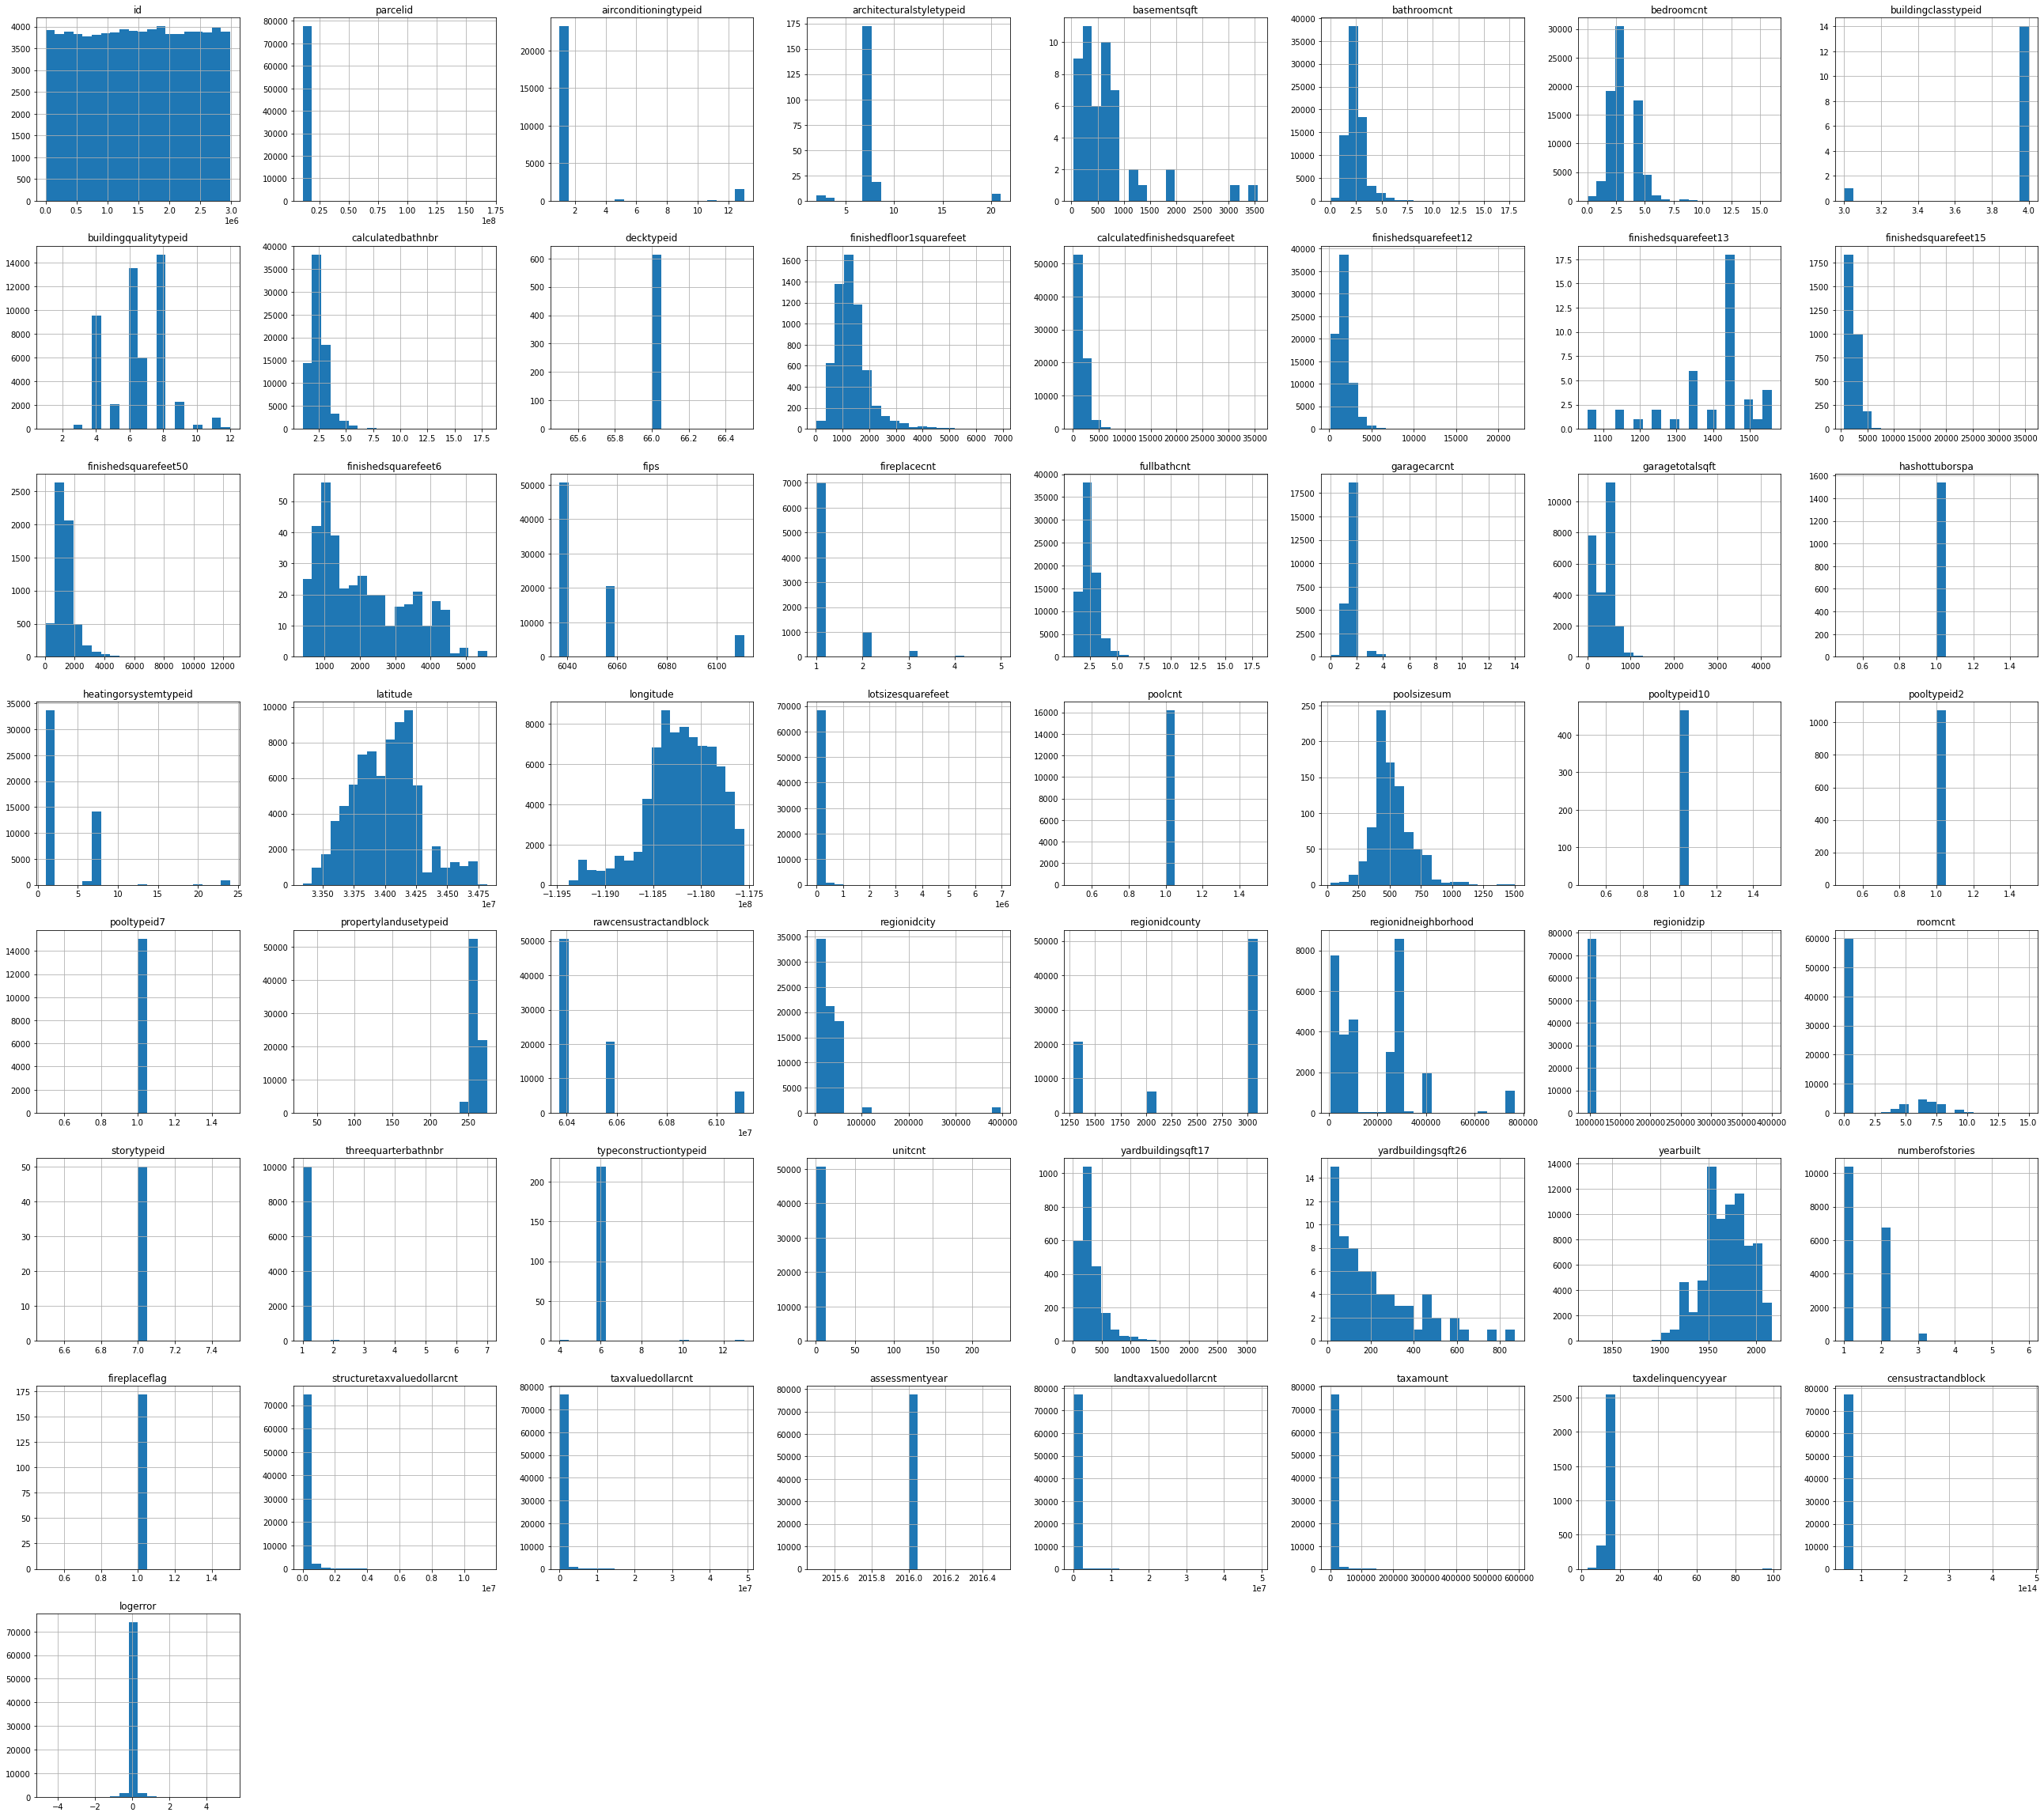

In [20]:
hist_data(zillow_data)

### 3. Nulls DataFrames

>### `nulls_by_col()` function

In [11]:
zillow_data.isnull()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,False,False,True,True,True,False,False,True,True,False,...,False,False,False,True,True,True,True,False,True,True
1,False,False,True,True,True,False,False,True,True,False,...,False,False,False,True,True,True,True,False,True,True
2,False,False,True,True,True,False,False,True,True,False,...,False,False,False,True,True,True,True,False,True,True
3,False,False,True,True,True,False,False,True,False,False,...,False,False,False,True,True,True,False,False,True,True
4,False,False,False,True,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,False,False,False,True,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,True
77570,False,False,True,True,True,False,False,True,False,False,...,False,False,False,True,True,True,False,False,True,True
77571,False,False,True,True,True,False,False,True,True,False,...,False,False,False,True,True,True,True,False,True,True
77572,False,False,False,True,True,False,False,True,False,False,...,False,False,False,False,True,True,False,False,True,True


In [12]:
zillow_data.isnull().sum().sort_values(ascending = False)

buildingclassdesc               77559
buildingclasstypeid             77559
finishedsquarefeet13            77532
storytypeid                     77524
basementsqft                    77524
storydesc                       77524
yardbuildingsqft26              77504
fireplaceflag                   77402
architecturalstyletypeid        77368
architecturalstyledesc          77368
typeconstructiondesc            77352
typeconstructiontypeid          77352
finishedsquarefeet6             77188
pooltypeid10                    77109
decktypeid                      76960
poolsizesum                     76705
pooltypeid2                     76500
hashottuborspa                  76035
yardbuildingsqft17              75181
taxdelinquencyyear              74674
taxdelinquencyflag              74674
finishedsquarefeet15            74547
finishedsquarefeet50            71539
finishedfloor1squarefeet        71539
fireplacecnt                    69287
threequarterbathnbr             67469
pooltypeid7 

In [13]:
def nulls_by_col(df):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND RETURNS THE NUMBER OF ROWS MISSING FOR EACH COLUMN AND THE 
PERCENTAGE OF MISSING MISSING ROWS TO TOTAL ROWS. THE VALUES ARE SORTED IN DESCENDING ORDER BY THE PERCENTAGE MISSING.

LASTLY, THE NUMBER OF MISSING ROWS FOR EACH COLUMN IS PLOTTED IN A HISTOGRAM.
    '''

    num_missing_rows = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing_rows / rows
    
    nulls_by_col_df = pd.DataFrame({'num_missing_rows': num_missing_rows, 'pct_rows_missing': pct_missing})\
    .sort_values(by = 'pct_rows_missing', ascending = False)\
    .reset_index().rename(columns = {'index': 'attribute'})
    
    nulls_by_col_df.num_missing_rows.hist(figsize=(8, 4), bins = 100)
    plt.title('Distribution of Missing Rows for Each Column')
    
    return nulls_by_col_df

NumExpr defaulting to 8 threads.


,attribute,num_missing_rows,pct_rows_missing
0,buildingclassdesc,77559,0.999807
1,buildingclasstypeid,77559,0.999807
2,finishedsquarefeet13,77532,0.999459
3,storytypeid,77524,0.999355
4,basementsqft,77524,0.999355
...,...,...,...
63,latitude,0,0.000000
64,fips,0,0.000000
65,bedroomcnt,0,0.000000
66,bathroomcnt,0,0.000000


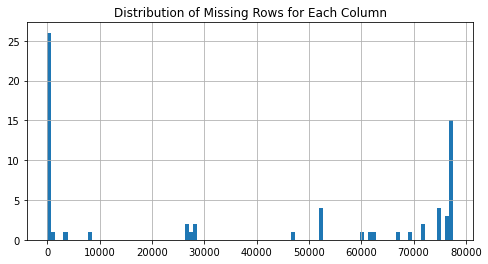

In [14]:
nulls_by_col(zillow_data)

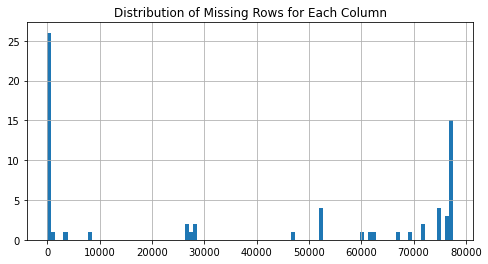

In [72]:
nulls_by_col_df = nulls_by_col(zillow_data)

>### `nulls_by_row()` function

Write a function that takes in a dataframe and returns a dataframe with 3 columns: 
- the number of columns missing, 
- percent of columns missing, and 
- number of rows with n columns missing. 

Run the function and document takeaways from this on how you want to handle missing values.

In [15]:
# number of nulls in each row

zillow_data.isnull().sum(axis = 1)

0        36
1        33
2        34
3        32
4        29
         ..
77569    29
77570    33
77571    32
77572    32
77573    34
Length: 77574, dtype: int64

In [16]:
zillow_data.isnull().sum(axis = 1).value_counts()

33    14817
34    13356
32    12606
31     9911
36     5793
29     5285
35     5163
37     3630
30     3465
38     1932
28      457
27      316
39      285
40      230
44       79
26       65
45       50
41       29
43       29
42       26
25       24
24       13
46        5
47        3
48        3
23        2
dtype: int64

>There are **14_817 `column1`** rows with **33 `column0`** null value columns

In [17]:
# creating a dataframe with col1 as the number of column values missing and col2 as the number of rows with
#     that many columns missing

pd.DataFrame(zillow_data.isnull().sum(axis = 1), columns = ['num_cols_missing']).reset_index()\
.groupby('num_cols_missing').count().reset_index().rename(columns = {'index': 'num_rows'})

,num_cols_missing,num_rows
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
...,...,...
21,44,79
22,45,50
23,46,5
24,47,3


In [18]:
# total number of columns, this will be the denominator of the pct_cols_missing fraction

zillow_data.shape[1]

68

In [19]:
def nulls_by_row(df):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND RETURNS INFORMATION ABOUT THE NUMBER OF COLUMN VALUES
MISSING FROM EACH ROW. 
    1) COL 1 IS THE NUMBER OF COLUMN VALUES MISSING
    2) COL 2 IS THE NUMBER OF ROWS WITH THAT MANY (COL 1) COLUMN VALUES MISSING
    3) COL 3 IS THE PERCENTAGE OF COLUMN VALUES MISSING TO THE TOTAL NUMBER OF COLUMNS
    
THIS INFORMATION IS RETURNED IN THE FORM OF A DATAFRAME AND SORTED IN DESCENDING ORDER BY THE
PERCENTAGE OF COLUMN VALUES MISSING.
    '''
    
    df2 = pd.DataFrame(df.isnull().sum(axis = 1), columns = ['num_cols_missing']).reset_index()\
    .groupby('num_cols_missing').count().reset_index().rename(columns = {'index': 'num_rows'})
    
    df2['pct_cols_missing'] = df2.num_cols_missing / df.shape[1]
    
    df2 = df2.sort_values(by = 'pct_cols_missing', ascending = False)
    
    return df2

In [92]:
nulls_by_row(zillow_data)

,num_cols_missing,num_rows,pct_cols_missing
25,48,3,0.705882
24,47,3,0.691176
23,46,5,0.676471
22,45,50,0.661765
21,44,79,0.647059
...,...,...,...
4,27,316,0.397059
3,26,65,0.382353
2,25,24,0.367647
1,24,13,0.352941


## Prepare

### 1. Remove non-single unit properties
Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). 
>There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, ***do not purely filter by unitcnt*** as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use `bedroomcnt`, `square feet`, `unit type` or the like to then identify those with unitcnt not defined.

#### first looking at homes that may have more than one unit

In [20]:
# value count of number of homes with each unit count

zillow_data.unitcnt.value_counts(dropna = False)

1.0      47412
NaN      26872
2.0       2031
4.0        726
3.0        529
42.0         1
237.0        1
45.0         1
6.0          1
Name: unitcnt, dtype: int64

>### We should drop homes with > 1 `unitcnt`

##### let's look at bedroom count next

In [21]:
zillow_data.bedroomcnt.value_counts(dropna = False)

3.0     30435
2.0     19222
4.0     17549
5.0      4550
1.0      3391
6.0      1000
0.0       836
8.0       253
7.0       208
9.0        70
10.0       31
12.0       16
11.0        9
13.0        2
14.0        1
16.0        1
Name: bedroomcnt, dtype: int64

In [22]:
# looking to see where a good cutoff will be to filter out bedroom count
#     creating a df of the counts of each bedroomct value

bedcnt_df = pd.DataFrame(zillow_data.bedroomcnt.value_counts(dropna = False)).reset_index()\
.rename(columns = {'index': 'bedcnt', 'bedroomcnt': 'count'})
bedcnt_df

,bedcnt,count
0,3.0,30435
1,2.0,19222
2,4.0,17549
3,5.0,4550
4,1.0,3391
...,...,...
11,12.0,16
12,11.0,9
13,13.0,2
14,14.0,1


<AxesSubplot:>

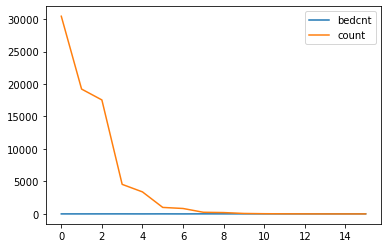

In [23]:
bedcnt_df.plot()

***woooooah***
### scaling the bedroom count, the range is so high that the count of each looks like a flat line

In [24]:
bedcnt_df

,bedcnt,count
0,3.0,30435
1,2.0,19222
2,4.0,17549
3,5.0,4550
4,1.0,3391
...,...,...
11,12.0,16
12,11.0,9
13,13.0,2
14,14.0,1


In [25]:
# using the minmaxscaler 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(bedcnt_df)

In [26]:
bedcnt_df['scaled_count'] = pd.DataFrame(scaled_df)[1]

In [27]:
bedcnt_df

,bedcnt,count,scaled_count
0,3.0,30435,1.000000
1,2.0,19222,0.631563
2,4.0,17549,0.576592
3,5.0,4550,0.149471
4,1.0,3391,0.111389
...,...,...,...
11,12.0,16,0.000493
12,11.0,9,0.000263
13,13.0,2,0.000033
14,14.0,1,0.000000


In [28]:
bedcnt_df['count'].sum()

77574

In [29]:
bedcnt_df['pct_of_total_count'] = bedcnt_df['count'] / bedcnt_df['count'].sum() * 100

# bedcnt_df['pct_total'] = 

In [30]:
bedcnt_df

,bedcnt,count,scaled_count,pct_of_total_count
0,3.0,30435,1.000000,39.233506
1,2.0,19222,0.631563,24.778921
2,4.0,17549,0.576592,22.622270
3,5.0,4550,0.149471,5.865367
4,1.0,3391,0.111389,4.371310
...,...,...,...,...
11,12.0,16,0.000493,0.020625
12,11.0,9,0.000263,0.011602
13,13.0,2,0.000033,0.002578
14,14.0,1,0.000000,0.001289


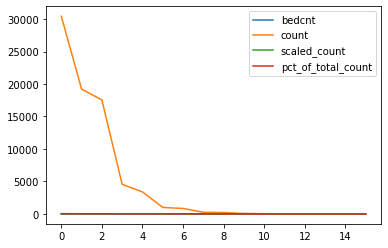

In [31]:
bedcnt_df.plot()
plt.show()

<AxesSubplot:>

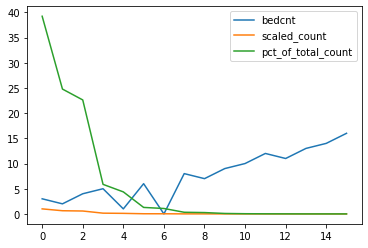

In [32]:
bedcnt_df.drop(columns = ['count']).plot()


>### 5 bedrooms appears to be a good cutoff for filtering out bedcnt and not losing too much data

#### Let's take a look at `propertylandusetypeid`

In [36]:
pd.set_option("min_rows", 13)
# pd.reset_option("min_rows")

# cross tab to show which codes belong to which property land use types
pd.crosstab(zillow_data.propertylandusetypeid, zillow_data.propertylandusedesc).T

propertylandusetypeid,31.0,246.0,247.0,248.0,260.0,261.0,263.0,264.0,265.0,266.0,267.0,269.0,275.0
propertylandusedesc,,,,,,,,,,,,,
Cluster Home,0,0,0,0,0,0,0,0,335,0,0,0,0
Commercial/Office/Residential Mixed Used,15,0,0,0,0,0,0,0,0,0,0,0,0
Condominium,0,0,0,0,0,0,0,0,0,19341,0,0,0
Cooperative,0,0,0,0,0,0,0,0,0,0,29,0,0
"Duplex (2 Units, Any Combination)",0,2021,0,0,0,0,0,0,0,0,0,0,0
"Manufactured, Modular, Prefabricated Homes",0,0,0,0,0,0,0,0,0,0,0,0,59
Mobile Home,0,0,0,0,0,0,74,0,0,0,0,0,0
Planned Unit Development,0,0,0,0,0,0,0,0,0,0,0,1947,0
"Quadruplex (4 Units, Any Combination)",0,0,0,729,0,0,0,0,0,0,0,0,0


>### `propertylandusetypedescr` I already know I will get rid of based on description:
- `Commercial/Office/Residential Mixed Used`
- `Cooperative`
- `Duplex (2 Units, Any Combination)`
- `Manufactured, Modular, Prefabricated Homes`
- `Planned Unit Development` 
- `Quadruplex (4 Units, Any Combination)`
- `Townhouse`
- `Triplex (3 Units, Any Combination)`

>### `propertylandusetypeid` I will keep for now:
- 265 `Cluster Home`
- 266 `Condominium`
- 263 `Mobile Home`
- 260 `Residential General`
- 261 `Single Family Residential`


In [37]:
np.sort(zillow_data.propertylandusetypeid)

array([ 31.,  31.,  31., ..., 275., 275., 275.])

In [44]:
np.sort(zillow_data[zillow_data.propertylandusetypeid.isin([260, 261, 263, 265, 266])]\
.propertylandusetypeid.unique())

array([260., 261., 263., 265., 266.])

In [45]:
for num in np.sort(zillow_data[zillow_data.propertylandusetypeid.isin([260, 261, 263, 265, 266])]\
.propertylandusetypeid.unique()):
    print(f'Property Land Type Use ID: {num.astype(int)}')
    print('-' * len(f'Property Land Type Use ID: {num.astype(int)}'))
    print('Unit Counts')
    print(zillow_data.unitcnt[zillow_data.propertylandusetypeid == num].value_counts())
    print()
    print()

Property Land Type Use ID: 260
------------------------------
Unit Counts
1.0    10
4.0     3
2.0     1
Name: unitcnt, dtype: int64


Property Land Type Use ID: 261
------------------------------
Unit Counts
1.0    33816
2.0       29
3.0        1
Name: unitcnt, dtype: int64


Property Land Type Use ID: 263
------------------------------
Unit Counts
1.0    53
Name: unitcnt, dtype: int64


Property Land Type Use ID: 265
------------------------------
Unit Counts
Series([], Name: unitcnt, dtype: int64)


Property Land Type Use ID: 266
------------------------------
Unit Counts
1.0    11527
2.0        5
3.0        2
6.0        1
Name: unitcnt, dtype: int64




>### testing `prepare` functions from `wrangle.py` file

In [69]:
import wrangle

In [70]:
zillow_data = wrangle.handle_missing_values(wrangle.one_unit_filters(zillow_data), .5, .7)

In [72]:
zillow_data.shape

(44918, 34)

### 2. `handle_missing_values()` function
Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row). **`handle_missing_values(df, prop_req_cols, prop_req_rows)`**
>The input:
- **`df`**A DataFrame
- **`prop_req_cols`**A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. ***i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).***
- **`prop_req_rows`** A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).

>The output:
- The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

>*Hint*
- *Look up dropna documentation*
- *Make use of inplace, i.e. `inplace=True/False`.*

In [61]:
type(round(.6 * len(zillow_data.index)))

int

In [62]:
def handle_missing_values(df, prop_req_cols, prop_req_rows):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND REMOVES NULL VALUES FROM COLUMNS AND THEN ROWS USING THE 
RESPECTIVE PROPORTIONS FED INTO IT USING THE DROPNA() FUNCTION.
    '''
    
    # to get the minimum non-null value threshold for keeping for keeping a column
    # a column must have at least this many non null values to be kept in the final df
    threshold = round(prop_req_cols * len(df.index))
    
    # takes in the above threshold and completes permanent drop of columns with less than
    # that many non null values
    df.dropna(axis =1, thresh = threshold, inplace = True)
    
    # to get the minimum non-null value threshold for keeping for keeping a row
    # a row must have at least this many non null values to be kept in the final df
    threshold = round(prop_req_rows * len(df.columns))
    
    # takes in the above threshold and completes permanent drop of columns with less than
    # that many non null values
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    return df    

In [66]:
handle_missing_values(zillow_data, .5, .7)

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
0,1727539,14297519,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,...,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,NaN,Single Family Residential
1,1387261,17052889,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,NaN,Single Family Residential
2,11677,14186244,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,NaN,Single Family Residential
3,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential
4,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Central,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,3.0,3.0,8.0,3.0,1741.0,1741.0,6037.0,3.0,...,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Central,Condominium
77570,673515,11000655,2.0,2.0,6.0,2.0,1286.0,1286.0,6037.0,2.0,...,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Central,Single Family Residential
77571,2968375,17239384,2.0,4.0,NaN,2.0,1612.0,1612.0,6111.0,2.0,...,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,NaN,Single Family Residential
77572,1843709,12773139,1.0,3.0,4.0,1.0,1032.0,1032.0,6037.0,1.0,...,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Central,Single Family Residential


### 3. Decide how to handle remaining missing values
- FIll with constant value
- Impute with mean, median, mode
- Drop row/column

In [75]:
# number of nulls for each column

zillow_data.isnull().sum().sort_values(ascending = False)

lotsizesquarefeet               1157
regionidcity                     915
heatingorsystemdesc              706
heatingorsystemtypeid            706
buildingqualitytypeid            457
propertyzoningdesc               192
censustractandblock              106
structuretaxvaluedollarcnt        63
calculatedbathnbr                 31
fullbathcnt                       31
regionidzip                       18
finishedsquarefeet12              17
yearbuilt                         14
calculatedfinishedsquarefeet       6
taxamount                          4
landtaxvaluedollarcnt              0
assessmentyear                     0
unitcnt                            0
taxvaluedollarcnt                  0
logerror                           0
transactiondate                    0
id                                 0
rawcensustractandblock             0
roomcnt                            0
regionidcounty                     0
parcelid                           0
propertylandusetypeid              0
p

In [80]:
#columns to remove (looking at values first)

zillow_data.censustractandblock.value_counts()
zillow_data.structuretaxvaluedollarcnt.value_counts()
zillow_data.fullbathcnt.value_counts()
zillow_data.unitcnt.value_counts()

cols_to_remove = ['censustractandblock', 'structuretaxvaluedollarcnt', 'fullbathcnt', 'unitcnt']

In [85]:
def remove_columns(df, cols_to_remove):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND DROPS THE SELECTED COLUMNS FROM IT.     
    '''
    
    df = df.drop(columns = cols_to_remove)
    
    return df

In [87]:
print(f'df before drop: {zillow_data.shape[1]}')
print(f'df after drop: {remove_columns(zillow_data, cols_to_remove).shape[1]}')

df before drop: 34
df after drop: 30


In [88]:
zillow_data = remove_columns(zillow_data, cols_to_remove)
zillow_data.shape

(44918, 30)

In [90]:
zillow_data.isnull().sum().sort_values(ascending = False)

lotsizesquarefeet               1157
regionidcity                     915
heatingorsystemtypeid            706
heatingorsystemdesc              706
buildingqualitytypeid            457
propertyzoningdesc               192
calculatedbathnbr                 31
regionidzip                       18
finishedsquarefeet12              17
yearbuilt                         14
calculatedfinishedsquarefeet       6
taxamount                          4
transactiondate                    0
logerror                           0
landtaxvaluedollarcnt              0
assessmentyear                     0
taxvaluedollarcnt                  0
roomcnt                            0
id                                 0
regionidcounty                     0
rawcensustractandblock             0
parcelid                           0
propertylandusetypeid              0
propertycountylandusecode          0
longitude                          0
latitude                           0
fips                               0
b

#### Looking for outliers

In [93]:
zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44918 entries, 3 to 77573
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            44918 non-null  int64  
 1   parcelid                      44918 non-null  int64  
 2   bathroomcnt                   44918 non-null  float64
 3   bedroomcnt                    44918 non-null  float64
 4   buildingqualitytypeid         44461 non-null  float64
 5   calculatedbathnbr             44887 non-null  float64
 6   calculatedfinishedsquarefeet  44912 non-null  float64
 7   finishedsquarefeet12          44901 non-null  float64
 8   fips                          44918 non-null  float64
 9   heatingorsystemtypeid         44212 non-null  float64
 10  latitude                      44918 non-null  float64
 11  longitude                     44918 non-null  float64
 12  lotsizesquarefeet             43761 non-null  float64
 13  p

In [96]:
zillow_data.dtypes

id                                int64
parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode        object
propertylandusetypeid           float64
propertyzoningdesc               object
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
taxvaluedollarcnt               float64
assessmentyear                  float64
landtaxvaluedollarcnt           float64


In [110]:
zillow_data.propertycountylandusecode.dtypes

dtype('O')

ID


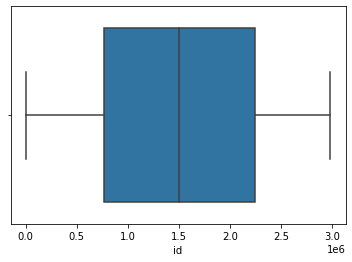



PARCELID


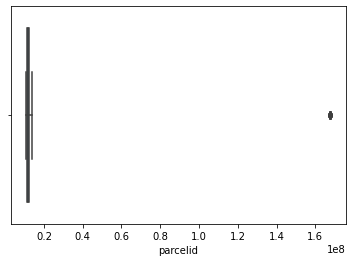



BATHROOMCNT


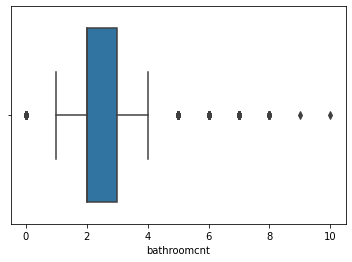



BEDROOMCNT


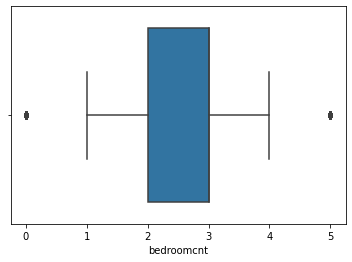



BUILDINGQUALITYTYPEID


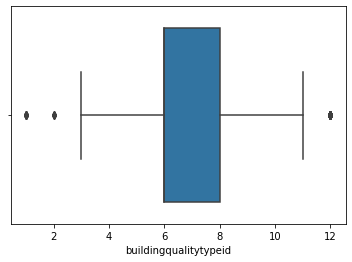



CALCULATEDBATHNBR


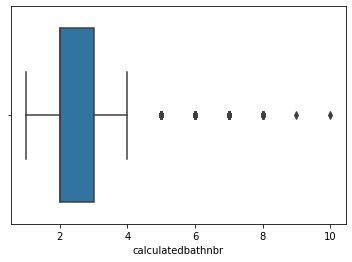



CALCULATEDFINISHEDSQUAREFEET


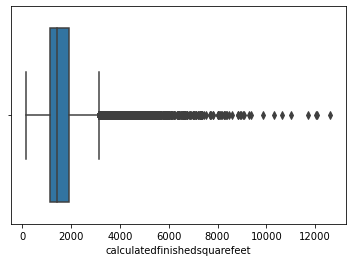



FINISHEDSQUAREFEET12


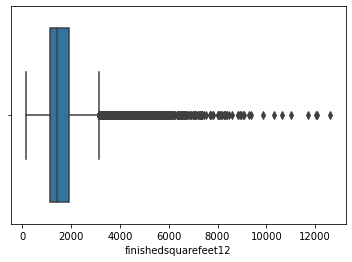



FIPS


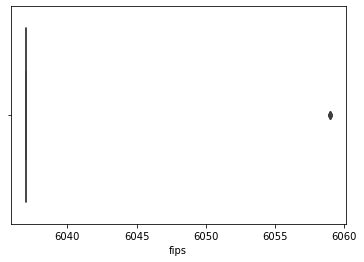



HEATINGORSYSTEMTYPEID


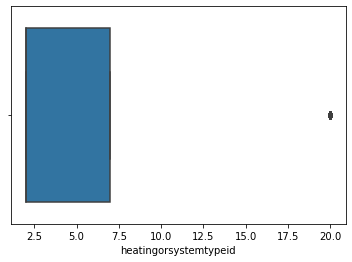



LATITUDE


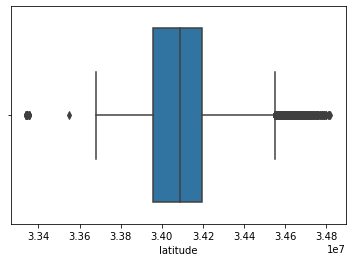



LONGITUDE


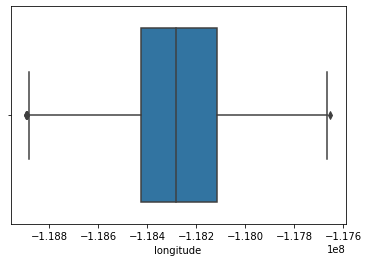



LOTSIZESQUAREFEET


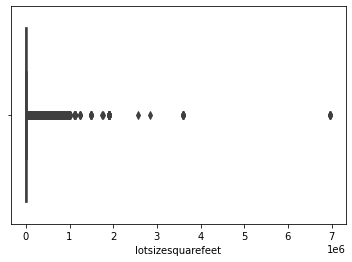



PROPERTYCOUNTYLANDUSECODE is a nonnumeric dtype


PROPERTYLANDUSETYPEID


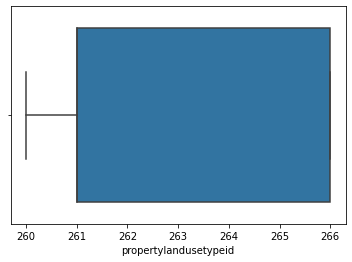



PROPERTYZONINGDESC is a nonnumeric dtype


RAWCENSUSTRACTANDBLOCK


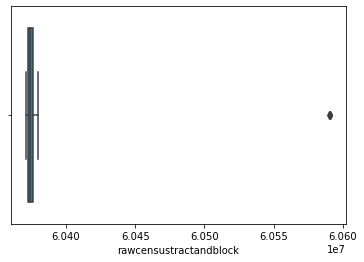



REGIONIDCITY


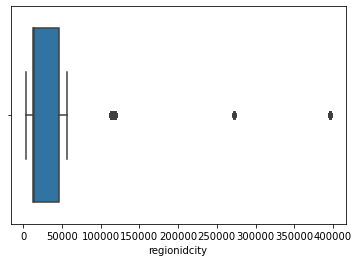



REGIONIDCOUNTY


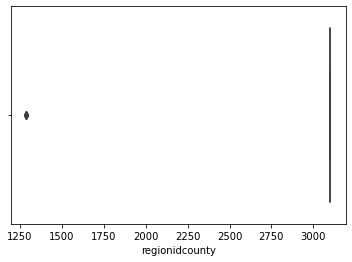



REGIONIDZIP


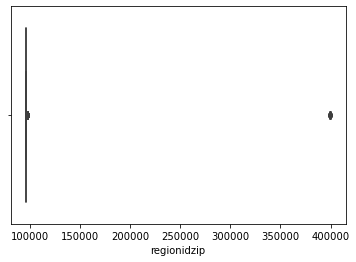



ROOMCNT


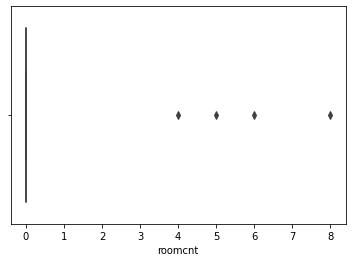



YEARBUILT


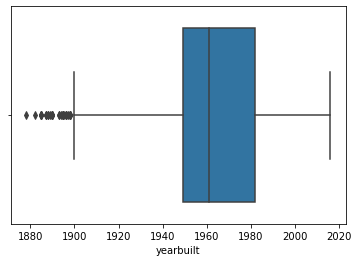



TAXVALUEDOLLARCNT


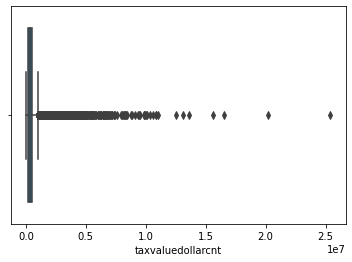



ASSESSMENTYEAR


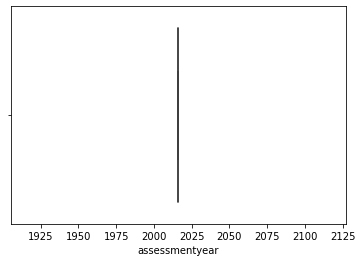



LANDTAXVALUEDOLLARCNT


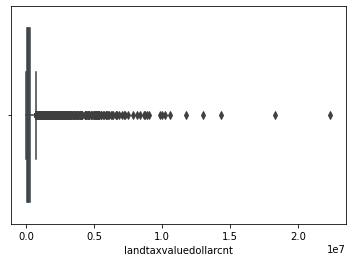



TAXAMOUNT


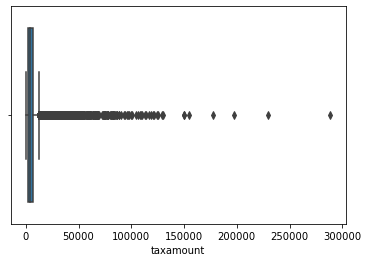



LOGERROR


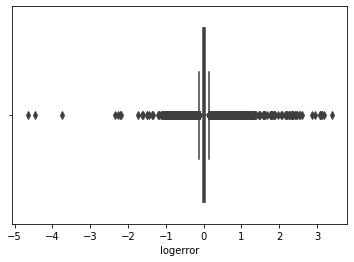



TRANSACTIONDATE


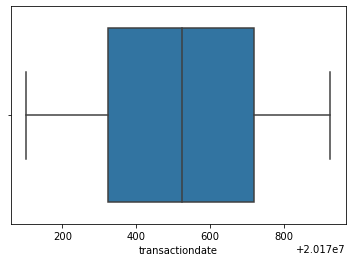



HEATINGORSYSTEMDESC is a nonnumeric dtype


PROPERTYLANDUSEDESC is a nonnumeric dtype




In [136]:
for col in zillow_data.columns:
    if zillow_data[col].dtypes != 'O':
        print(col.upper())
        sns.boxplot(x = col, data = zillow_data)
        plt.show()
        print()
        print()
    else:
        print(f'{col.upper()} is a nonnumeric dtype')
        print()
        print()

>### Come back and convert date to int in prepare function

<AxesSubplot:xlabel='transactiondate'>

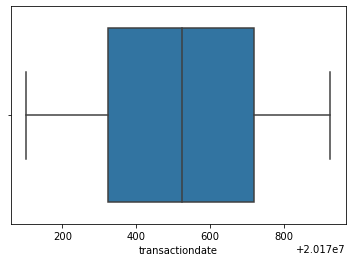

In [133]:
# date converted to numeric dtype, boxplot
sns.boxplot(x = zillow_data.transactiondate.replace('-', '', regex = True).astype('int'), data = zillow_data)

In [129]:
zillow_data.transactiondate.replace('-', '', regex = True).astype('int')

3        20170101
4        20170101
6        20170101
7        20170101
8        20170102
           ...   
77568    20170919
77569    20170920
77570    20170920
77572    20170921
77573    20170925
Name: transactiondate, Length: 44918, dtype: int64

In [135]:
zillow_data.transactiondate = zillow_data.transactiondate.replace('-', '', regex = True).astype('int')

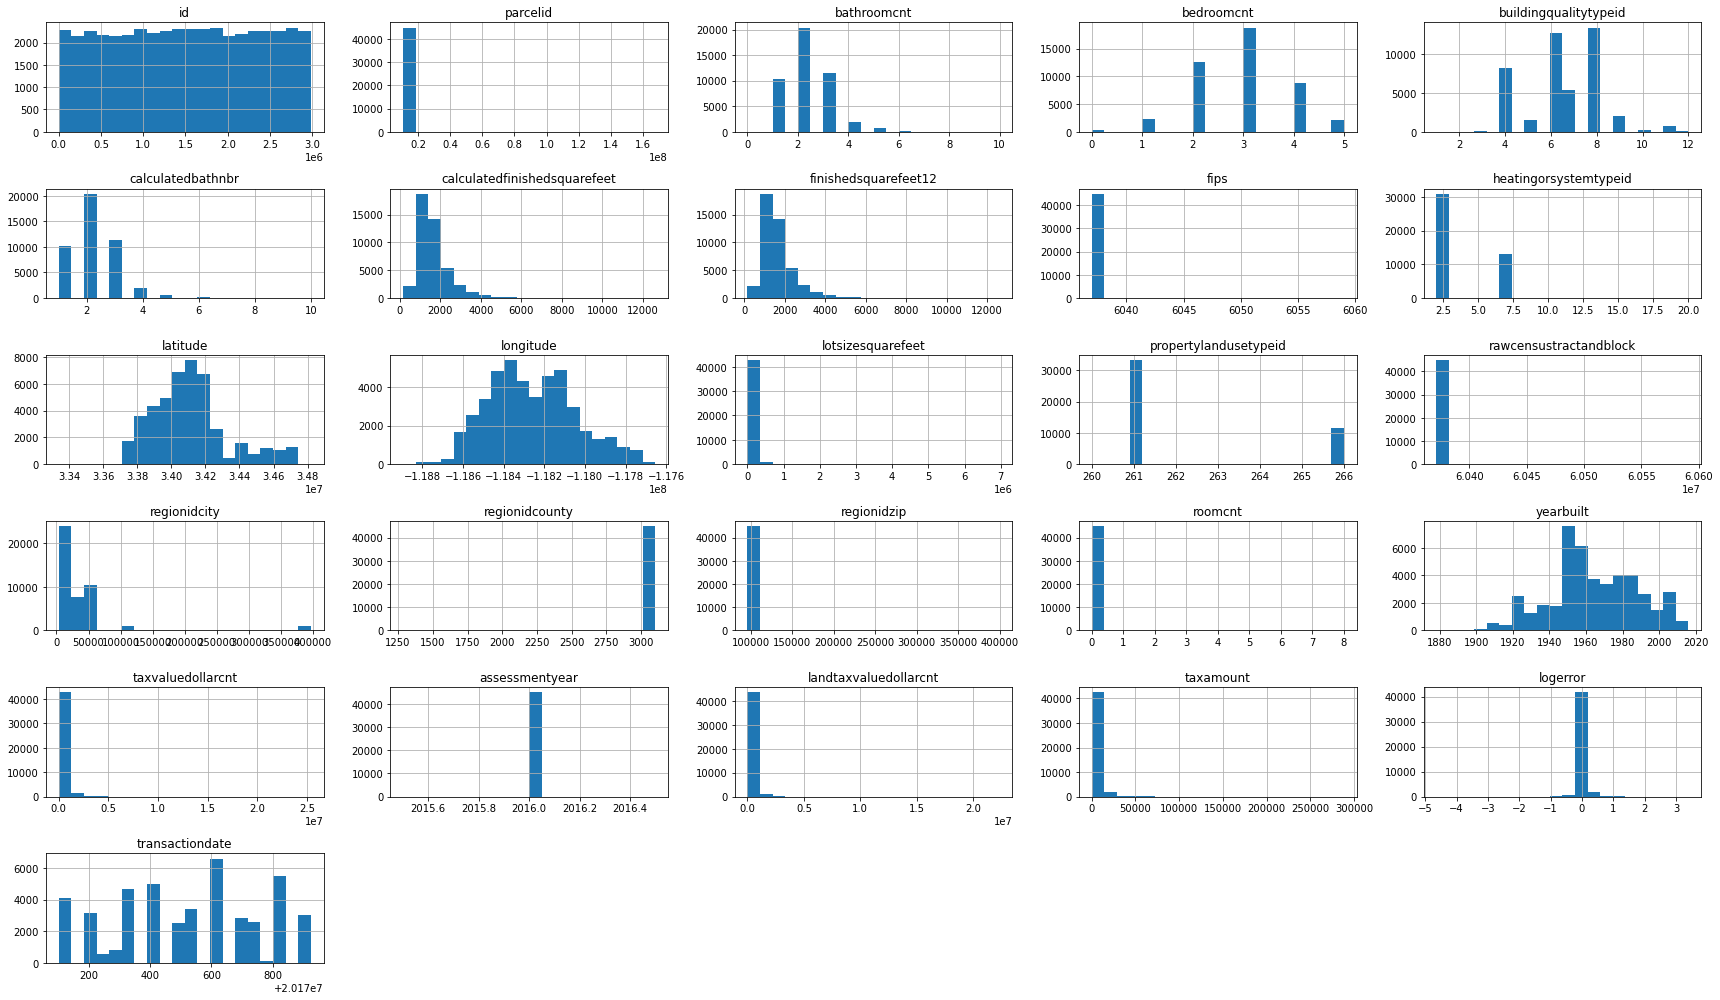

In [138]:
zillow_data.hist(figsize=(24, 14), bins=20)
plt.tight_layout();

In [141]:
df = wrangle.acquire_data('zillow_data.csv', 'zillow', query)

In [146]:
def wrangle_zillow(df):
    df = pd.read_csv('zillow.csv')
    
    # Restrict df to only properties that meet single unit use criteria
    single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    
    # Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>350)]

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df, .5, .7)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange', 
                                   'Ventura'))    
    # drop columns not needed
    df = remove_columns(df, ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc','heatingorsystemdesc','unitcnt'
                            ,'buildingqualitytypeid'])


    # replace nulls in unitcnt with 1
#     df.unitcnt.fillna(1, inplace = True)
    
    # assume that since this is Southern CA, null means 'None' for heating system
#     df.heatingorsystemdesc.fillna('None', inplace = True)
    
    # replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7313, inplace = True)
#     df.buildingqualitytypeid.fillna(6.0, inplace = True)

    # Columns to look for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df[df.calculatedfinishedsquarefeet < 8000]
    
    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    
    return df

In [147]:
df = wrangle_zillow(df)

In [148]:
df.shape

(69729, 23)

# Mall Customers
<hr>

#### notebook
1. Acquire data from mall_customers.customers in mysql database.
2. Summarize data (include distributions and descriptive statistics).
3. Detect outliers using IQR.
4. Split data (train, validate, and test split).
5. Encode categorical columns using a one hot encoder (pd.get_dummies).
6. Handles missing values.
7. Scaling

#### `wrangle_mall.py`
1. Acquire data from mall_customers.customers in mysql database.
2. Split the data into train, validate, and split
3. One-hot-encoding (pd.get_dummies)
4. Missing values
5. Scaling

### 1. Acquire data

In [149]:
mall_query = 'select * from customers'

In [151]:
mall_df = wrangle.acquire_data('mall_data.csv', 'mall_customers', mall_query)

### 2. Summarize data

In [153]:
wrangle.summarize_data(mall_df, 20)

1) DATAFRAME SHAPE
---------------
Rows: 200
Columns: 5


2) DATAFRAME INFO
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


3) UNIQUE VALUES BY COLUMN
-----------------------
CUSTOMER_ID
-----------
Number of Unique Values for customer_id: 200
This column has > 20 values


GENDER
------
Number of Unique Values for gender: 2
Female    112
Male       88
Name: gender, dtype: int64


AGE
---
Number of Unique Values for age: 51
This column has > 20 values


ANNUAL_INCOME
-------------
Number of Unique Values for annual_income: 64
This column has > 20 values


SPE

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


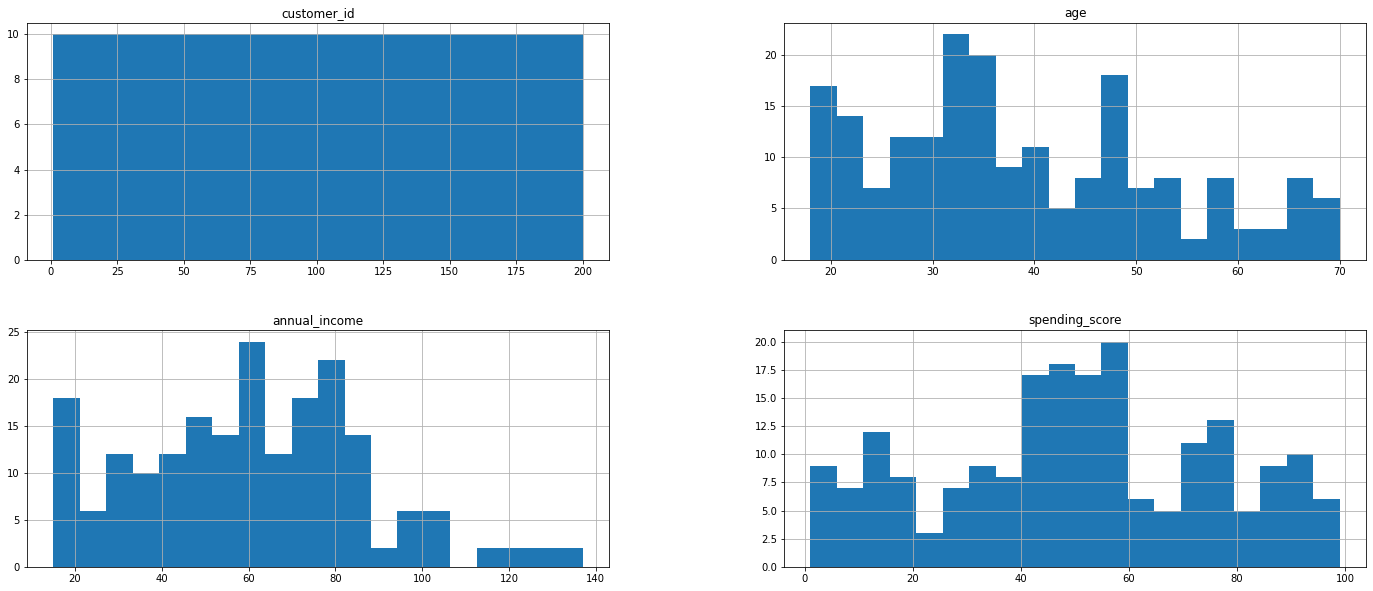

In [157]:
mall_df.hist(figsize=(24, 10), bins=20);

In [160]:
def outlier_boxplots(df):
    '''
THIS FUNCTION TAKES IN A DATAFRAME AND, FOR ALL NUMERIC COLUMNS, DISPLAYS HORIZONTAL
BOXPLOTS ALLOWING OUTLIERS TO BE VISUALIZED. IF A COLUMN IS NON-NUMERIC THEN THE COLUMN
NAME ALONG WITH A PRINT STATEMENT WILL BE EXECUTED.
    '''
    
    for col in df.columns:
        if df[col].dtypes != 'O':
            print(col.upper())
            sns.boxplot(x = col, data = df)
            plt.show()
            print()
            print()
        else:
            print(f'{col.upper()} is a nonnumeric dtype')
            print()
            print()

CUSTOMER_ID


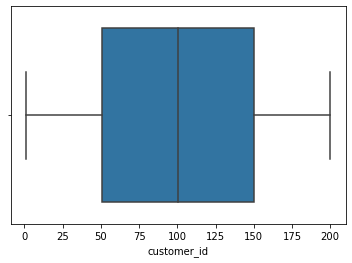



GENDER is a nonnumeric dtype


AGE


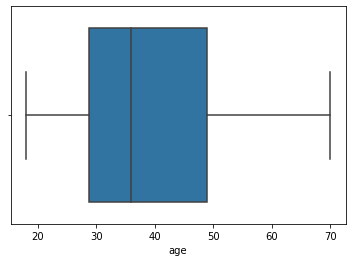



ANNUAL_INCOME


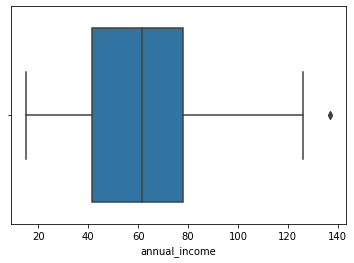



SPENDING_SCORE


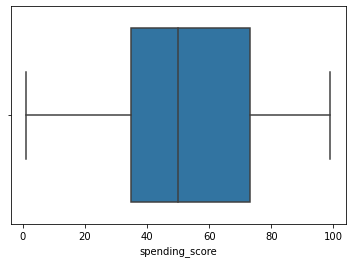

In [161]:
outlier_boxplots(mall_df)

### 3. Detect outliers

In [162]:
# Calculate q1, q3 and iqr for income

q1 = mall_df.annual_income.quantile(0.25)
q3 = mall_df.annual_income.quantile(0.75)
iqr = q3 - q1
k = 1.5

# calculate upper and lower ranges
upper_bound_income =  q3 + k * iqr
lower_bound_income =  q1 - k * iqr

upper_bound_income

132.75

In [163]:
# columns that will be eliminated

mall_df[mall_df.annual_income > upper_bound_income]

,customer_id,gender,age,annual_income,spending_score
198,199,Male,32,137,18
199,200,Male,30,137,83


In [166]:
mall_df = mall_df[(mall_df.annual_income < upper_bound_income) & (mall_df.annual_income > lower_bound_income)]

In [167]:
mall_df.shape

(198, 5)

In [168]:
mall_df.set_index('customer_id')

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
194,Female,38,113,91
195,Female,47,120,16
196,Female,35,120,79


### 5. Encode categorical `gender` column using OneHotEncoder

In [169]:
dummy_df = pd.get_dummies(mall_df.gender, drop_first = True)
dummy_df.head()

,Male
0,1
1,1
2,0
3,0
4,0


In [170]:
# concat with df and drop gender column

mall_df = pd.concat([mall_df, dummy_df], axis = 1).drop(columns = ['gender'])
mall_df.head()

,customer_id,age,annual_income,spending_score,Male
0,1,19,15,39,1
1,2,21,15,81,1
2,3,20,16,6,0
3,4,23,16,77,0
4,5,31,17,40,0


In [172]:
mall_df.set_index('customer_id', inplace=True)

### 4. Train, validate, test split

In [173]:
train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
train, validate = train_test_split(train, train_size = 0.75, random_state = 123)

In [174]:
train.shape, validate.shape, test.shape

((118, 4), (40, 4), (40, 4))

### 6. Scale Numeric Columns

In [175]:
train.head()

,age,annual_income,spending_score,Male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1


In [178]:
train.select_dtypes('number').columns

Index(['age', 'annual_income', 'spending_score', 'Male'], dtype='object')

In [179]:
def min_max_scaler(train, valid, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    
    scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    
    train[num_vars] = scaler.fit_transform(train[num_vars])
    
    valid[num_vars] = scaler.transform(valid[num_vars])
    
    test[num_vars] = scaler.transform(test[num_vars])
    
    return scaler, train, valid, test

In [180]:
# use the scaler
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [181]:
train_scaled.head()

,age,annual_income,spending_score,Male
customer_id,,,,
182,0.269231,0.738739,0.867347,0.0
49,0.211538,0.225225,0.418367,0.0
35,0.596154,0.162162,0.132653,0.0
186,0.230769,0.756757,0.979592,1.0
114,0.019231,0.441441,0.459184,1.0


In [187]:
# function to detect and eliminate outliers using IQR rule

def outlier_function(df, cols, k):
    for col in df[cols]:
        q1 = mall_df.annual_income.quantile(0.25)
        q3 = mall_df.annual_income.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [198]:
def wrangle_mall_df():
    
    # acquire data
    sql = 'select * from customers'
    mall = wrangle.acquire_data('mall_data.csv', 'mall_customers', mall_query)
    
    # handle outliers
    mall = outlier_function(mall, ['age', 'spending_score', 'annual_income'], 1.5)
    
    # get dummy for gender column
    dummy_df = pd.get_dummies(mall.gender, drop_first=True)
    mall = pd.concat([mall, dummy_df], axis=1).drop(columns = ['gender'])
    mall.rename(columns= {'Male': 'is_male'}, inplace = True)

    # split the data in train, validate and test
    train, test = train_test_split(mall, train_size = 0.8, random_state = 123)
    train, validate = train_test_split(train, train_size = 0.75, random_state = 123)
    
    return min_max_scaler, train, validate, test

In [199]:
min_max_scaler, train, validate, test = wrangle_mall_df()

In [200]:
train.head()

,customer_id,age,annual_income,spending_score,is_male
181,182,32,97,86,0
48,49,29,40,42,0
34,35,49,33,14,0
185,186,30,99,97,1
113,114,19,64,46,1


In [192]:
#scaled the values
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [211]:
train_scaled.head()

,customer_id,age,annual_income,spending_score,is_male
181,0.923469,0.269231,0.738739,0.867347,0.0
48,0.244898,0.211538,0.225225,0.418367,0.0
34,0.173469,0.596154,0.162162,0.132653,0.0
185,0.943878,0.230769,0.756757,0.979592,1.0
113,0.576531,0.019231,0.441441,0.459184,1.0


<AxesSubplot:>

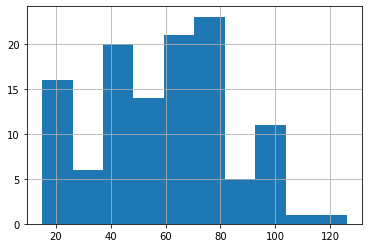

In [212]:
train.annual_income.hist()

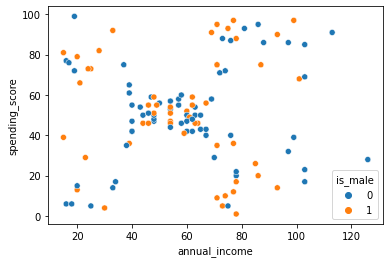

In [217]:
sns.scatterplot(data = train, x = 'annual_income', y = 'spending_score', hue = 'is_male')
plt.show()